# Carcinoma Cells Classification

The following steps are performed in this task

1. Preprocessing:
   - Loading and preprocessing the HES stained images. As mentioned, cropping may miss target cells, and resizing may change features, so it's recommended to maintain the original image sizes if possible. Normalize the pixel values to a consistent range (e.g., [0, 1]).

2. Prepare the labeled data:
   - Spliting the labeled dataset (62 images) into training, validation, and test sets, maintaining a balanced class distribution. We have used 80% of the data for training, 10% for validation and remaining 10% for testing.

3. Transfer learning with pretrained models:
   - We have used Vgg16, Vgg19 and Resnet50.
   - Modifying the last fully connected layer to match the number of classes in your task (3 classes: -1, 0, 1).
   - Freezing the weights of the pretrained layers.

4. Training with labeled data:
   - Using the labeled training set to train the modified model, following the steps mentioned earlier.

5. Pseudo-labeling for unlabeled data:
   - Using the trained model to predict labels for the unlabeled images.
   - Assigning pseudo-labels to the unlabeled images based on the model's predictions. These pseudo-labels act as proxies for the true labels.
   - Combining the labeled training set and the unlabeled data with their pseudo-labels to create a larger training set.

6. Semi-supervised learning training:
   - Training the model on the combined training set (labeled + pseudo-labeled unlabeled) using appropriate loss functions that take into account both the labeled and unlabeled samples.
   - Common techniques for semi-supervised learning include entropy minimization, consistency regularization, or using a combination of supervised and unsupervised losses.

7. Evaluation and fine-tuning:
   - Evaluating the trained model on the labeled test set to measure its performance using appropriate evaluation metrics.
   - If needed, fine-tune the model by unfreezing and updating some of the pretrained layers while keeping others frozen.

8. Predicting on unlabeled data:
   - Using the trained model to predict the class labels of the remaining unlabeled images.
   - Applying the same preprocessing steps used during training and pass the unlabeled images through the model to obtain predictions.

In [165]:
import os
import shutil
import pandas as pd

# Define the paths to the image folder, CSV file, and the output folders
image_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification"
csv_file = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labels.csv"
labeled_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data"
non_labeled_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/non-labeled-data"

# Create the output folders if they don't exist
os.makedirs(labeled_folder, exist_ok=True)
os.makedirs(non_labeled_folder, exist_ok=True)

# Read the CSV file containing the image labels
labels_df = pd.read_csv(csv_file)

# Convert the values in the 'id' column to a set
labeled_ids = set(labels_df['id'].values)

# Iterate over the image files in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".png"):  # Modify the file extension if necessary
        image_id = int(os.path.splitext(filename)[0].split("_")[-1])  # Extract and convert the image ID to an integer
        
        if image_id in labeled_ids:
            # If the image ID is found in the CSV file, move it to the labeled folder
            shutil.move(os.path.join(image_folder, filename), os.path.join(labeled_folder, filename))
        else:
            # If the image ID is not found in the CSV file, move it to the non-labeled folder
            shutil.move(os.path.join(image_folder, filename), os.path.join(non_labeled_folder, filename))


# Preprocessing

In [166]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the paths to the labeled dataset, CSV file, and the output folders for splits
labeled_dataset_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/"
csv_file = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/labels.csv"
output_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/"

# Read the CSV file
labels_df = pd.read_csv(csv_file)

print(labels_df)

        id  malignant
0      441         -1
1    33284         -1
2    38771          1
3    46784         -1
4    57613         -1
..     ...        ...
57  918503         -1
58  931650         -1
59  955514          0
60  965412         -1
61  984782         -1

[62 rows x 2 columns]


In [28]:
# Define the paths to the labeled dataset and CSV file
labeled_dataset_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/"
csv_file = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/labels.csv"

# Read the CSV file
labels_df = pd.read_csv(csv_file)

# Create the output folders for each class
class_neg_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/-1"
class_benign_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/0"
class_malignant_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/1"

os.makedirs(class_neg_folder, exist_ok=True)
os.makedirs(class_benign_folder, exist_ok=True)
os.makedirs(class_malignant_folder, exist_ok=True)

# Iterate over the labeled images and move them to the corresponding class folders
for index, row in labels_df.iterrows():
    image_id = row['id']
    image_class = row['malignant']
    image_file = f"img_{image_id}.png"  # Assuming the image file extension is PNG

    src_path = os.path.join(labeled_dataset_folder, image_file)

    if image_class == -1:
        dest_folder = class_neg_folder
    elif image_class == 0:
        dest_folder = class_benign_folder
    elif image_class == 1:
        dest_folder = class_malignant_folder
    else:
        continue

    dest_path = os.path.join(dest_folder, image_file)

    shutil.copy(src_path, dest_path)


In [2]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data'
class1 = '/-1'
class2 = '/0'
class3 = '/1'
################# Training ################
os.makedirs(root_dir +'/train' + class1)
os.makedirs(root_dir +'/train' + class2)
os.makedirs(root_dir +'/train' + class3)
################# Validation ################
os.makedirs(root_dir +'/val' + class1)
os.makedirs(root_dir +'/val' + class2)
os.makedirs(root_dir +'/val' + class3)
################# Testing ################
os.makedirs(root_dir +'/test' + class1)
os.makedirs(root_dir +'/test' + class2)
os.makedirs(root_dir +'/test' + class3)

# Creating partitions of the data after shuffeling
currentCls = class1
src = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data" + currentCls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
print("Image Split for -1 class")
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/test"+currentCls)


Image Split for -1 class
Total images:  36
Training:  25
Validation:  5
Testing:  6


In [3]:
currentCls = class2
src = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/" + currentCls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
print("Image Split for 0 class")
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/test"+currentCls)

Image Split for 0 class
Total images:  14
Training:  9
Validation:  2
Testing:  3


In [4]:
currentCls = class3
src = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/" + currentCls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
print("Image Split for 1 class")
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/test"+currentCls)

Image Split for 0 class
Total images:  12
Training:  8
Validation:  2
Testing:  2


In [2]:
import os
import random
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Set the random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Define the paths to the labeled and non-labeled image folders
labeled_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/"
# non_labeled_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/non-labeled-data/"

# Define the transformation pipeline including normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor
])

# Load the labeled dataset
labeled_dataset = ImageFolder(root=labeled_folder, transform=transform)

# Create a DataLoader for the labeled dataset
labeled_dataloader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Preparing Models

In [1]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import math

model_urls = {
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()      

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg16(pretrained=False, model_root=None, **kwargs):
    """VGG 16-layer model (configuration "A")"""
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16'], model_root))
    return model


def vgg16_bn(**kwargs):
    """VGG 16-layer model (configuration "A") with batch normalization"""
    kwargs.pop('model_root', None)
    return VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)


def vgg19(pretrained=False, model_root=None, **kwargs):
    """VGG 19-layer model (configuration "B")"""
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19'], model_root))
    return model


def vgg19_bn(**kwargs):
    """VGG 19-layer model (configuration 'B') with batch normalization"""
    kwargs.pop('model_root', None)
    return VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)


In [2]:
vgg16 = vgg16(True)

In [3]:
vgg19 = vgg19(True)

In [5]:
# Freeze the weights of the pretrained layers
for param in vgg16.parameters():
    param.requires_grad = False
    
# Freeze the weights of the pretrained layers
for param in vgg19.parameters():
    param.requires_grad = False

In [6]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Dataloader for Labeled Data

In [8]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Define the paths to the labeled data folders
labeled_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data/"
train_folder = os.path.join(labeled_folder, "train")
test_folder = os.path.join(labeled_folder, "test")
val_folder = os.path.join(labeled_folder, "val")

# Define the target size for resizing
target_size = (224, 224)  # Adjust the size as needed

# Define the transformation pipeline including resizing and normalization
transform = transforms.Compose([
    transforms.Resize(target_size),  # Resize images to the target size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image tensor
])

# Create ImageFolder datasets for train, test, and val folders with the specified transformation
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
val_dataset = ImageFolder(root=val_folder, transform=transform)

# Create DataLoaders for train, test, and val datasets
batch_size = 32  # Adjust the batch size as needed
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print label values along with images in train_dataloader
for batch in train_dataloader:
    images, labels = batch
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        print("Label: {}, Image Shape: {}".format(label, image.shape))

# Print label values along with images in test_dataloader
for batch in test_dataloader:
    images, labels = batch
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        print("Label: {}, Image Shape: {}".format(label, image.shape))

# Print label values along with images in val_dataloader
for batch in val_dataloader:
    images, labels = batch
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        print("Label: {}, Image Shape: {}".format(label, image.shape))

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Label: 1, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 2, Image Shape: torch.Size([3, 224, 224])
Label: 2, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 2, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 1, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 1, Image Shape: torch.Size([3, 224, 224])
Label: 0, Image Shape: torch.Size([3, 224, 224])
Label: 1, Image Shap

In [9]:
# Check the number of images in train_dataloader
train_images = len(train_dataloader.dataset)
print("Number of images in train_dataloader:", train_images)

# Check the number of images in test_dataloader
test_images = len(test_dataloader.dataset)
print("Number of images in test_dataloader:", test_images)

# Check the number of images in val_dataloader
val_images = len(val_dataloader.dataset)
print("Number of images in val_dataloader:", val_images)

Number of images in train_dataloader: 42
Number of images in test_dataloader: 11
Number of images in val_dataloader: 9


# Training Vgg16 on Labeled Data

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# Load the pre-trained VGG16 model
# model = vgg16

num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, 3)  # Replace with the number of classes

# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = vgg16.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Set the number of training epochs
num_epochs = 10

# Variables to track the best validation loss and corresponding model state
best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation
    vgg16.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = vgg16(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')

    # Check if the current model has a better validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = vgg16.state_dict()

# Save the best model checkpoint in the specified directory
save_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model_vgg16.pth')
torch.save(best_model_state, save_path)

Epoch [1/10], Loss: 1.0578, Accuracy: 0.4048
Validation Loss: 0.9926, Accuracy: 0.4444, F1 Score: 0.3419
Epoch [2/10], Loss: 0.9528, Accuracy: 0.5000
Validation Loss: 0.9765, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [3/10], Loss: 0.9347, Accuracy: 0.5952
Validation Loss: 1.0347, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [4/10], Loss: 0.7307, Accuracy: 0.6190
Validation Loss: 1.0027, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [5/10], Loss: 0.9848, Accuracy: 0.5952
Validation Loss: 0.9179, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [6/10], Loss: 0.6705, Accuracy: 0.6667
Validation Loss: 0.8644, Accuracy: 0.5556, F1 Score: 0.4929
Epoch [7/10], Loss: 0.6945, Accuracy: 0.7143
Validation Loss: 0.8736, Accuracy: 0.7778, F1 Score: 0.7901
Epoch [8/10], Loss: 0.7856, Accuracy: 0.7143
Validation Loss: 0.8400, Accuracy: 0.5556, F1 Score: 0.5556
Epoch [9/10], Loss: 0.6838, Accuracy: 0.7143
Validation Loss: 0.7861, Accuracy: 0.4444, F1 Score: 0.4040
Epoch [10/10], Loss: 0.7052, Accuracy: 0.7143
Validatio

# Evaluation on Labeled Data using Vgg16

In [11]:
from sklearn.metrics import accuracy_score
# Load the best saved checkpoint
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/best_model_vgg16.pth'
checkpoint = torch.load(checkpoint_path)
vgg16.load_state_dict(checkpoint)
# Set the model to evaluation mode
vgg16.eval()

# Testing on the test set
total_test = 0
correct_test = 0
predictions = []
targets = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

test_accuracy = correct_test / total_test
test_f1 = f1_score(targets, predictions, average='weighted')

print(f'Test Accuracy for vgg16 : {test_accuracy:.4f}')
print(f'Test F1 Score for vgg16 : {test_f1:.4f}')

Test Accuracy for vgg16 : 0.4545
Test F1 Score for vgg16 : 0.3409


# Training Vgg19 on Labeled Data

In [49]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

num_features = vgg19.classifier[-1].in_features
vgg19.classifier[-1] = nn.Linear(num_features, 3)  # Replace with the number of classes

# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19 = vgg19.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

# Set the number of training epochs
num_epochs = 10

# Variables to track the best validation loss and corresponding model state
best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation
    vgg19.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = vgg19(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')

    # Check if the current model has a better validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = vgg19.state_dict()

# Save the best model checkpoint in the specified directory
save_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model_vgg19.pth')
torch.save(best_model_state, save_path)

Epoch [1/10], Loss: 1.1138, Accuracy: 0.4762
Validation Loss: 1.0005, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [2/10], Loss: 1.2026, Accuracy: 0.5000
Validation Loss: 0.9954, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [3/10], Loss: 0.9960, Accuracy: 0.5476
Validation Loss: 0.9904, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [4/10], Loss: 0.9527, Accuracy: 0.5714
Validation Loss: 0.9795, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [5/10], Loss: 0.9381, Accuracy: 0.5714
Validation Loss: 0.9652, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [6/10], Loss: 0.8237, Accuracy: 0.6429
Validation Loss: 0.9562, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [7/10], Loss: 0.7050, Accuracy: 0.6905
Validation Loss: 0.9455, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [8/10], Loss: 0.7094, Accuracy: 0.6429
Validation Loss: 0.9348, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [9/10], Loss: 0.6789, Accuracy: 0.6429
Validation Loss: 0.9308, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [10/10], Loss: 0.6105, Accuracy: 0.7381
Validatio

# Evaluation on Labeled Data using Vgg19

In [50]:
from sklearn.metrics import accuracy_score
# Load the best saved checkpoint
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/best_model_vgg19.pth'
checkpoint = torch.load(checkpoint_path)
vgg19.load_state_dict(checkpoint)

# Set the model to evaluation mode
vgg19.eval()

# Testing on the test set
total_test = 0
correct_test = 0
predictions = []
targets = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg19(images)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

test_accuracy = correct_test / total_test
test_f1 = f1_score(targets, predictions, average='weighted')

print(f'Test Accuracy for vgg19 : {test_accuracy:.4f}')
print(f'Test F1 Score for vgg19 : {test_f1:.4f}')

Test Accuracy for vgg19 : 0.5455
Test F1 Score for vgg19 : 0.3850


# Training Resnet50 on Labeled Data

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
import os

# Load the pretrained ResNet50 model
resnet50 = resnet50(pretrained=True)

# Modify the last layer for the new classification task
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 3)  # Replace with the number of classes

# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

# Set the number of training epochs
num_epochs = 10

# Define variables to track the best model
best_val_loss = float('inf')
best_model_state = None

# Set the path to save the best model checkpoint
save_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/'

# Training loop
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation
    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet50(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')

    # Check if the current model has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = resnet50.state_dict()
        
        # Save the best model checkpoint
        checkpoint_path = os.path.join(save_dir, 'best_model_res50.pth')
        torch.save(best_model_state, checkpoint_path)

print('Training complete.')

/home/ahmad/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmad/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.1349, Accuracy: 0.2619
Validation Loss: 1.0156, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [2/10], Loss: 0.9413, Accuracy: 0.5952
Validation Loss: 1.0464, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [3/10], Loss: 0.9086, Accuracy: 0.5952
Validation Loss: 1.1614, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [4/10], Loss: 1.0676, Accuracy: 0.5952
Validation Loss: 1.1850, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [5/10], Loss: 0.7967, Accuracy: 0.5952
Validation Loss: 1.0985, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [6/10], Loss: 0.6633, Accuracy: 0.6667
Validation Loss: 1.0353, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [7/10], Loss: 0.5425, Accuracy: 0.9286
Validation Loss: 1.0131, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [8/10], Loss: 0.5634, Accuracy: 1.0000
Validation Loss: 0.9997, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [9/10], Loss: 0.4788, Accuracy: 0.9762
Validation Loss: 1.0234, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [10/10], Loss: 0.5220, Accuracy: 0.9048
Validatio

# Evaluation on Labeled Data using Resnet50

In [21]:
# Load the best saved checkpoint
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/best_model_res50.pth'
checkpoint = torch.load(checkpoint_path)
resnet50.load_state_dict(checkpoint)

# Evaluation on the test set
resnet50.eval()
total_test = 0
correct_test = 0
predictions = []
targets = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

test_accuracy = correct_test / total_test
test_f1 = f1_score(targets, predictions, average='weighted')

print(f'Test Accuracy for resnet50 : {test_accuracy:.4f}')
print(f'Test F1 Score for resnet50 : {test_f1:.4f}')

Test Accuracy for resnet50 : 0.3636
Test F1 Score for resnet50 : 0.2909


__In the above experiments with three models (vgg16, vgg19, and resnet50). Vgg16 and vgg19 have performed well on labeled data. So vgg16 and vgg19 are used in further training and testing on non labeled data for this task__

# Further Fine Tuning

In [19]:
# Load the pre-trained VGG16 model
vgg16_model = vgg16

# Create a new model
class NewModel(nn.Module):
    def __init__(self, vgg_model):
        super(NewModel, self).__init__()
        self.features = vgg_model.features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 1024),  # Adjust the input size based on the VGG16 model
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),  # Replace with the number of classes
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the new model
new_model = NewModel(vgg16_model)

# Print the new model architecture
print(new_model)

NewModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [20]:
# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model = new_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

# Set the number of training epochs
num_epochs = 20

# Set the path to save the checkpoints
save_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/'

# Initialize variables for tracking best model
best_val_acc = 0.0
best_model_path = None

# Training loop
for epoch in range(num_epochs):
    new_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = new_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation
    new_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')

    # Save the checkpoint if it's the best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(save_dir, 'best_model.pth')
        torch.save(new_model.state_dict(), best_model_path)
        print("Best model saved.")

print('Training complete.')

Epoch [1/20], Loss: 1.0952, Accuracy: 0.4524
Validation Loss: 1.0985, Accuracy: 0.5556, F1 Score: 0.5185
Best model saved.
Epoch [2/20], Loss: 1.0952, Accuracy: 0.5476
Validation Loss: 1.0974, Accuracy: 0.5556, F1 Score: 0.5185
Epoch [3/20], Loss: 1.0922, Accuracy: 0.5476
Validation Loss: 1.0961, Accuracy: 0.4444, F1 Score: 0.3419
Epoch [4/20], Loss: 1.0894, Accuracy: 0.6190
Validation Loss: 1.0946, Accuracy: 0.4444, F1 Score: 0.3419
Epoch [5/20], Loss: 1.0822, Accuracy: 0.5952
Validation Loss: 1.0928, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [6/20], Loss: 1.0789, Accuracy: 0.5952
Validation Loss: 1.0907, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [7/20], Loss: 1.0695, Accuracy: 0.5952
Validation Loss: 1.0886, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [8/20], Loss: 1.0650, Accuracy: 0.5952
Validation Loss: 1.0862, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [9/20], Loss: 1.0594, Accuracy: 0.5952
Validation Loss: 1.0837, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [10/20], Loss: 1.0581, Accuracy

In [22]:
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/best_model.pth'
checkpoint = torch.load(checkpoint_path)
new_model.load_state_dict(checkpoint)

# Evaluation on the test set
new_model.eval()
total_test = 0
correct_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = new_model(images)
        _, predicted = torch.max(outputs, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

test_accuracy = correct_test / total_test
test_f1 = f1_score(targets, predictions, average='weighted')

print(f'Test Accuracy for modified vgg16 : {test_accuracy:.4f}')
print(f'Test F1 Score for modified vgg16 : {test_f1:.4f}')

Test Accuracy for modified vgg16 : 0.5455
Test F1 Score for modified vgg16 : 0.4201


Epoch [1/20], Loss: 1.1175, Accuracy: 0.2143
Validation Loss: 1.1042, Accuracy: 0.3333, F1 Score: 0.2741
Best model saved.
Epoch [2/20], Loss: 1.1109, Accuracy: 0.2143
Validation Loss: 1.1014, Accuracy: 0.3333, F1 Score: 0.2741
Epoch [3/20], Loss: 1.1161, Accuracy: 0.1667
Validation Loss: 1.0975, Accuracy: 0.3333, F1 Score: 0.2575
Epoch [4/20], Loss: 1.1048, Accuracy: 0.3095
Validation Loss: 1.0930, Accuracy: 0.5556, F1 Score: 0.4274
Best model saved.
Epoch [5/20], Loss: 1.0987, Accuracy: 0.3333
Validation Loss: 1.0884, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [6/20], Loss: 1.0755, Accuracy: 0.5476
Validation Loss: 1.0833, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [7/20], Loss: 1.0862, Accuracy: 0.5000
Validation Loss: 1.0779, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [8/20], Loss: 1.0838, Accuracy: 0.5000
Validation Loss: 1.0730, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [9/20], Loss: 1.0611, Accuracy: 0.6429
Validation Loss: 1.0687, Accuracy: 0.5556, F1 Score: 0.3968
Epoch [10/20], Loss

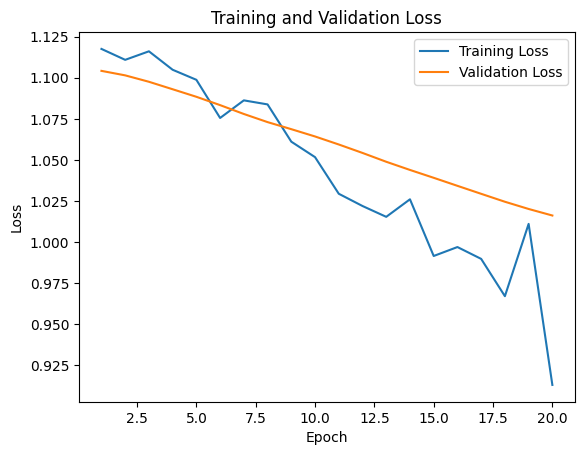

Training complete.


In [26]:
import matplotlib.pyplot as plt

vgg16_model = vgg16

# Freeze all layers except the final convolutional layer
for param in vgg16_model.parameters():
    param.requires_grad = False

# Get the number of input features for the fully connected layers
num_features = vgg16_model.classifier[0].in_features

# Create a new model
class NewModel(nn.Module):
    def __init__(self, vgg_model, num_features):
        super(NewModel, self).__init__()
        self.features = vgg_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 3),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create an instance of the new model
new_model_vgg16 = NewModel(vgg16_model, num_features)

# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model_vgg16 = new_model_vgg16.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model_vgg16.parameters(), lr=0.001, momentum=0.9)

# Set the number of training epochs
num_epochs = 20

# Create lists to store the loss values
train_losses = []
val_losses = []

# Set the path to save the best model
save_dir = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/'

# Initialize variables for tracking best model
best_val_acc = 0.0
best_model_path = None

# Training loop
for epoch in range(num_epochs):
    new_model_vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = new_model_vgg16(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation
    new_model_vgg16.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model_vgg16(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation loss, accuracy, and F1 score
    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}')
    
    # Append the loss values to the lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    # Save the checkpoint if it's the best model so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(save_dir, 'best_model_vgg16_modified.pth')
        torch.save(new_model_vgg16.state_dict(), best_model_path)
        print("Best model saved.")

# Plot the training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print('Training complete.')

# Dataloader For Unlabeled Data

In [51]:
non_labeled_data_path = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/non-labeled-data"
import os
from PIL import Image
from torch.utils.data import Dataset

class UnlabeledDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.file_list = os.listdir(self.folder_path)
        self.transform = transform

    def __getitem__(self, index):
        image_path = os.path.join(self.folder_path, self.file_list[index])
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.file_list)

# Create the unlabeled dataset
unlabeled_dataset = UnlabeledDataset(folder_path=non_labeled_data_path, transform=transform)

In [52]:
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)
print(unlabeled_dataloader)

In [53]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader

class LabeledDataset(Dataset):
    def __init__(self, labels_csv_file, images_folder, transform=None):
        self.labels_df = pd.read_csv(labels_csv_file)
        self.images_folder = images_folder
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.labels_df.loc[index, 'id']
        image_class = self.labels_df.loc[index, 'malignant']
        image_path = os.path.join(self.images_folder, f"img_{image_id}.png")

        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Replace labels: -1 -> 0, 0 -> 1, 1 -> 2
        if image_class == -1:
            image_class = 0
        elif image_class == 0:
            image_class = 1
        elif image_class == 1:
            image_class = 2

        return image, image_class


    def __len__(self):
        return len(self.labels_df)

# Set the paths to the labels CSV file and the images folder
labels_csv_file = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labels.csv"
images_folder = "/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/labeled-data"

# Create the labeled dataset
labeled_dataset = LabeledDataset(labels_csv_file, images_folder, transform=transform)

# Create a data loader for the labeled dataset
batch_size = 32  # Adjust the batch size as needed
labeled_dataloader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)

In [54]:
print("Image Names and Labels:")
for index in range(len(labeled_dataset)):
    image, label = labeled_dataset[index]
    image_name = f"img_{index}.png"
    print("Image:", image_name, "Label:", label)

Image Names and Labels:
Image: img_0.png Label: 0
Image: img_1.png Label: 0
Image: img_2.png Label: 2
Image: img_3.png Label: 0
Image: img_4.png Label: 0
Image: img_5.png Label: 1
Image: img_6.png Label: 1
Image: img_7.png Label: 1
Image: img_8.png Label: 1
Image: img_9.png Label: 1
Image: img_10.png Label: 0
Image: img_11.png Label: 2
Image: img_12.png Label: 1
Image: img_13.png Label: 0
Image: img_14.png Label: 1
Image: img_15.png Label: 1
Image: img_16.png Label: 0
Image: img_17.png Label: 1
Image: img_18.png Label: 0
Image: img_19.png Label: 2
Image: img_20.png Label: 0
Image: img_21.png Label: 2
Image: img_22.png Label: 2
Image: img_23.png Label: 1
Image: img_24.png Label: 0
Image: img_25.png Label: 0
Image: img_26.png Label: 0
Image: img_27.png Label: 2
Image: img_28.png Label: 0
Image: img_29.png Label: 0
Image: img_30.png Label: 2
Image: img_31.png Label: 0
Image: img_32.png Label: 0
Image: img_33.png Label: 2
Image: img_34.png Label: 0
Image: img_35.png Label: 0
Image: img_36.

# Pseudo-labeling Using Vgg19

In [55]:
labeled_dataset = labeled_dataloader.dataset
unlabeled_dataset = unlabeled_dataloader.dataset

# Load the best saved checkpoint
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/best_model_vgg19.pth'
checkpoint = torch.load(checkpoint_path)
vgg19.load_state_dict(checkpoint)

pseudo_labels = []
vgg19.eval()
with torch.no_grad():
    for images in unlabeled_dataloader:
        images = images.to(device)
        outputs = vgg19(images)
        _, predicted_labels = torch.max(outputs, dim=1)
        pseudo_labels.extend(predicted_labels.tolist())
        
# Create pseudo-labeled dataset by combining the original labeled dataset and pseudo-labels
pseudo_labeled_dataset = []
for i in range(len(unlabeled_dataset)):
    image = unlabeled_dataset[i]
    label = pseudo_labels[i]
    pseudo_labeled_dataset.append((image, label))

combined_dataset = torch.utils.data.ConcatDataset([labeled_dataset, pseudo_labeled_dataset])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


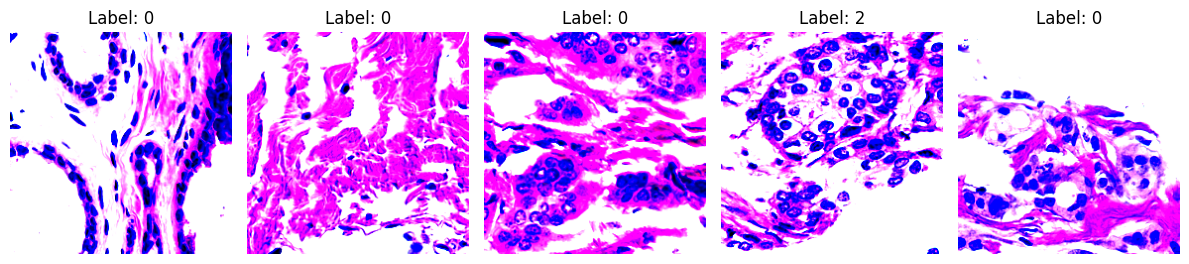

In [56]:
import random
import matplotlib.pyplot as plt

# Select a few random samples from the combined dataset
num_samples = 5
selected_indices = random.sample(range(len(combined_dataset)), num_samples)
selected_samples = [combined_dataset[i] for i in selected_indices]

# Plot the selected samples
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i, (image, label) in enumerate(selected_samples):
    # Display the image and label
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title('Label: {}'.format(label))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [57]:
print("Total number of images in combined_dataset:", len(combined_dataset))
print()
# Display image names and labels in the combined dataset
for image, label in combined_dataset:
    image_name = image[0]  # Assuming the image name is stored as the first element of the image tensor
    print("Image:", image_name, "Label:", label)

Total number of images in combined_dataset: 186

Image: tensor([[1.1529, 1.3927, 1.4612,  ..., 1.3927, 1.6838, 1.7009],
        [0.7762, 0.8104, 0.4166,  ..., 1.6495, 1.5982, 1.6324],
        [1.0502, 0.9646, 0.4508,  ..., 1.9578, 1.8893, 1.8893],
        ...,
        [2.1119, 2.0777, 2.0948,  ..., 0.8104, 1.7694, 1.7352],
        [2.1290, 2.0948, 2.1119,  ..., 0.5536, 1.2214, 1.8550],
        [2.1633, 2.0948, 2.1119,  ..., 0.4851, 0.6392, 1.8037]]) Label: 0
Image: tensor([[ 1.4954,  1.5125,  1.5810,  ..., -0.6965, -1.3644, -1.4843],
        [ 1.5468,  1.5639,  1.5468,  ..., -0.3027, -1.0733, -1.5014],
        [ 1.5639,  1.6153,  1.5468,  ..., -0.0116, -0.4568, -0.9363],
        ...,
        [-0.7479, -0.8335,  0.0056,  ..., -0.3027, -0.8849, -1.2959],
        [-0.8164, -0.9192, -0.5253,  ..., -0.0458, -0.9363, -1.3815],
        [-0.8507, -0.8849, -0.5596,  ...,  0.2111, -0.7137, -1.3130]]) Label: 0
Image: tensor([[1.5810, 1.6153, 1.7009,  ..., 1.6153, 1.6667, 1.6667],
        [1.4098,

Image: tensor([[ 1.5468,  1.5125,  1.4954,  ...,  2.1290,  2.0948,  2.0948],
        [ 1.5468,  1.4954,  1.4440,  ...,  2.1290,  2.1290,  2.1290],
        [ 1.5125,  1.4612,  1.3584,  ...,  2.1633,  2.1462,  2.1633],
        ...,
        [-0.7479, -0.4568, -0.5938,  ..., -0.6452, -1.0562, -1.1075],
        [-0.7479, -0.5424, -0.5767,  ..., -0.7308, -1.1075, -1.1932],
        [-0.3541, -0.3712, -0.7650,  ..., -0.7650, -1.0219, -1.1589]]) Label: 2
Image: tensor([[0.9988, 0.8618, 0.6734,  ..., 0.5707, 0.7077, 0.9988],
        [1.3584, 1.2899, 1.2043,  ..., 1.5810, 1.6838, 1.7694],
        [1.8550, 1.7523, 1.6838,  ..., 1.9407, 1.6838, 1.7180],
        ...,
        [2.1975, 2.1975, 2.2489,  ..., 2.1633, 2.1462, 2.1633],
        [2.1804, 2.2147, 2.2489,  ..., 2.1804, 2.1633, 2.1804],
        [2.1633, 2.2147, 2.2318,  ..., 2.1804, 2.1633, 2.1633]]) Label: 2
Image: tensor([[2.2318, 2.2318, 2.2318,  ..., 2.1290, 2.0777, 2.1290],
        [2.2147, 2.2147, 2.2318,  ..., 2.1290, 2.0605, 2.0092],
 

Image: tensor([[1.8379, 1.9235, 1.9407,  ..., 1.8208, 1.7865, 1.8037],
        [2.0434, 2.0434, 1.9749,  ..., 1.8379, 1.8208, 1.8208],
        [1.9749, 1.8893, 1.8208,  ..., 1.8550, 1.9407, 1.9407],
        ...,
        [1.6495, 1.6838, 1.8893,  ..., 2.0434, 2.0263, 2.0092],
        [1.8208, 1.5639, 1.7352,  ..., 1.9749, 1.9407, 1.9920],
        [2.0434, 1.6667, 1.6153,  ..., 1.9064, 1.9064, 1.9920]]) Label: 0
Image: tensor([[-0.4054, -0.0972,  0.3652,  ...,  2.2147,  2.1975,  2.2147],
        [-0.2856, -0.1828,  0.0912,  ...,  2.2147,  2.1975,  2.2147],
        [ 0.6563,  0.3823,  0.3994,  ...,  2.1975,  2.1975,  2.1975],
        ...,
        [ 2.0434,  2.0948,  2.0777,  ...,  2.1290,  2.1290,  2.1290],
        [ 1.9578,  1.9920,  2.0263,  ...,  2.1290,  2.1119,  2.1119],
        [ 2.0777,  1.9920,  1.9407,  ...,  2.0777,  2.0777,  2.0777]]) Label: 0
Image: tensor([[2.0092, 2.0263, 2.0948,  ..., 2.0948, 2.0777, 2.0948],
        [2.0434, 2.0605, 2.1290,  ..., 2.0777, 2.0434, 2.0605],
 

# Semi Supervised Learning

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Set the seed for reproducibility
torch.manual_seed(42)

# Define the transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming you have labeled_dataset and unlabeled_dataset as the labeled and unlabeled datasets

# Split the combined dataset into training, validation, and testing sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
num_samples = len(combined_dataset)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the loss functions for labeled and unlabeled samples
labeled_loss_fn = nn.CrossEntropyLoss()
unlabeled_loss_fn = nn.CrossEntropyLoss(reduction='none')  # Replace with the appropriate unsupervised loss function
# Set the device to 'cuda' if available, otherwise use 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg19 = vgg19.to(device)

# Set up the optimizer and learning rate scheduler
optimizer = SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training on Labeled + Pseudo-labeled Ulabeled

In [63]:
######## VGG19 is used for Training #########
# Training loop
best_val_loss = float('inf')
best_model_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/final_model_vgg19.pth'

for epoch in range(num_epochs):
    # Training phase
    vgg19.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass for labeled samples
        labeled_outputs = vgg19(images)
        labeled_loss = labeled_loss_fn(labeled_outputs, labels)

        # Forward pass for unlabeled samples
        # Replace the following code with your own implementation
        unlabeled_images = images  # Example: using the same images for illustration
        pseudo_labels = torch.zeros_like(labels)  # Example: assigning zeros as pseudo labels
        unlabeled_outputs = vgg19(unlabeled_images)
        unlabeled_loss = unlabeled_loss_fn(unlabeled_outputs, pseudo_labels)

        # Compute the total loss
        total_loss = labeled_loss + unlabeled_loss

        # Compute the mean loss over the batch
        mean_loss = total_loss.mean()

        # Backward pass and optimization
        mean_loss.backward()
        optimizer.step()

    scheduler.step()

    # Validation phase
    vgg19.eval()
    val_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = vgg19(images)
            val_loss += labeled_loss_fn(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Training Loss: {mean_loss.item():.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Save the best model if the current validation loss is lower than the previous best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vgg19.state_dict(), best_model_path)
        print("Best model saved.")

Epoch 1/10: Training Loss: 1.5663, Validation Loss: 0.8956, Validation Accuracy: 77.78%
Best model saved.
Epoch 2/10: Training Loss: 1.5744, Validation Loss: 0.8954, Validation Accuracy: 77.78%
Best model saved.
Epoch 3/10: Training Loss: 1.6055, Validation Loss: 0.8963, Validation Accuracy: 77.78%
Epoch 4/10: Training Loss: 1.5239, Validation Loss: 0.8964, Validation Accuracy: 77.78%
Epoch 5/10: Training Loss: 1.6276, Validation Loss: 0.8956, Validation Accuracy: 77.78%
Epoch 6/10: Training Loss: 1.5180, Validation Loss: 0.8954, Validation Accuracy: 77.78%
Epoch 7/10: Training Loss: 1.6185, Validation Loss: 0.8955, Validation Accuracy: 77.78%
Epoch 8/10: Training Loss: 1.6062, Validation Loss: 0.8957, Validation Accuracy: 77.78%
Epoch 9/10: Training Loss: 1.5906, Validation Loss: 0.8963, Validation Accuracy: 77.78%
Epoch 10/10: Training Loss: 1.5153, Validation Loss: 0.8957, Validation Accuracy: 77.78%


# Evaluation Using Vgg16

In [69]:
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/final_model_vgg16.pth'
checkpoint = torch.load(checkpoint_path)

if 'model_state_dict' in checkpoint:
    vgg16.load_state_dict(checkpoint['model_state_dict'])
else:
    vgg16.load_state_dict(checkpoint)

# Testing phase
vgg16.eval()
test_loss = 0.0
total_samples = 0
correct_predictions = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = vgg16(images)
        test_loss += labeled_loss_fn(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Collect predicted and true labels for computing F1 score
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
accuracy = correct_predictions / total_samples
f1score = f1_score(all_labels, all_predicted, average='weighted')

print("***************** Final Accuracy Using VGG16 *****************")
print(f"Testing Loss: {test_loss:.4f}, "
      f"Testing Accuracy: {accuracy * 100:.2f}%, "
      f"F1 Score: {f1score:.4f}")

***************** Final Accuracy Using VGG16 *****************
Testing Loss: 0.6622, Testing Accuracy: 70.00%, F1 Score: 0.7412


# Evaluation Using Vgg19

In [70]:
checkpoint_path = '/home/ahmad/Desktop/Cancer Classification Task/carinoma-classification/checkpoints/final_model_vgg19.pth'
checkpoint = torch.load(checkpoint_path)

if 'model_state_dict' in checkpoint:
    vgg19.load_state_dict(checkpoint['model_state_dict'])
else:
    vgg19.load_state_dict(checkpoint)

# Testing phase
vgg19.eval()
test_loss = 0.0
total_samples = 0
correct_predictions = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = vgg19(images)
        test_loss += labeled_loss_fn(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Collect predicted and true labels for computing F1 score
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
accuracy = correct_predictions / total_samples
f1score = f1_score(all_labels, all_predicted, average='weighted')

print("***************** Final Accuracy Using VGG19 *****************")
print(f"Testing Loss: {test_loss:.4f}, "
      f"Testing Accuracy: {accuracy * 100:.2f}%, "
      f"F1 Score: {f1score:.4f}")

***************** Final Accuracy Using VGG19 *****************
Testing Loss: 0.8341, Testing Accuracy: 90.00%, F1 Score: 0.8526
